#Given a budget of 30 million dollar (or less) and genre, can I predict gross domestic profit using linear regression?

In [118]:
%matplotlib inline
import pickle
from pprint import pprint
import pandas as pd
import numpy as np
from dateutil.parser import parse
import math
# For plotting
import seaborn as sb
import matplotlib.pyplot as plt

# For linear regression
from patsy import dmatrices
from patsy import dmatrix
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation

In [119]:
def perform_linear_regression(df, axes, title):
    plot_data = df.sort('budget', ascending = True)
    

    y, X = dmatrices('log_gross ~ budget', data = plot_data, return_type = 'dataframe')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
    
    columns = ['budget']
    #Patsy
    model = sm.OLS(y_train,X_train)
    fitted = model.fit()
    r_squared =  fitted.rsquared
    pval = fitted.pvalues
    params = fitted.params



    #Plotting
    axes.plot(X_train[columns], y_train, 'go')
    #axes.plot(X_test[columns], y_test, 'yo')
    #axes.plot(X_test[columns], fitted.predict(X_test), 'ro')
    axes.plot(X[columns], fitted.predict(X), '-')
    
    axes.set_title('{0} (Rsquared = {1:.2f})  p = {2:.2f}'.format(title, r_squared, pval[1]))
    axes.set_xlabel('Budget')
    axes.set_ylabel('ln(Gross)')
    return None



In [120]:
def perform_linear_regression1(df, axes, title):
    plot_data = df.sort('budget', ascending = True)
    

    y, X = dmatrices('log_gross ~ budget', data = plot_data, return_type = 'dataframe')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
    
    columns = ['budget']
    #Patsy
    model = sm.OLS(y_train,X_train)
    fitted = model.fit()
    r_squared =  fitted.rsquared
    pval = fitted.pvalues
    params = fitted.params
    y_test = y_test
    #Plotting
    #axes.plot(X_train[columns], y_train, 'go')
    axes.plot(X_test[columns], y_test, 'yo')
    #axes.plot(X_test[columns], fitted.predict(X_test), 'ro')
    
    
    axes.plot(X[columns], fitted.predict(X), '-')
    
    axes.set_title('{0} (Rsquared = {1:.2f}) p = {2:.2f}'.format(title, r_squared, pval[1]))
    axes.set_xlabel('Budget')
    axes.set_ylabel('ln(Gross)')
    return None



In [121]:
def perform_linear_regression_all(df, axes, title):
    plot_data = df.sort('budget', ascending = True)
    

    y, X = dmatrices('log_gross ~ budget', data = plot_data, return_type = 'dataframe')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
    
    columns = ['budget']
    #Patsy
    model = sm.OLS(y_train,X_train)
    fitted = model.fit()
    r_squared =  fitted.rsquared
    pval = fitted.pvalues
    params = fitted.params
    
    #Plotting
    axes.plot(X_train[columns], y_train, 'go')
    
    axes.set_title('{0}'.format(title))
    axes.set_xlabel('Budget')
    axes.set_ylabel('ln(Gross)')
    return None



In [7]:
def create_genre_column(df, genre):
    return df['genre'].apply(lambda x: 1 if genre in x else 0)

In [8]:
def get_genre_dataframes(df, genre):
    columns = ['log_gross', 'gross', 'log_budget', 'budget', 'runtime', 'budget_squared']
    df_out = df.copy()[df[genre] == 1][columns]
    df_out['genre'] = genre
    return df_out

###Load the movie dictionary

In [9]:
d = pickle.load(open('movie_dictionary.p'))

In [136]:
#Create a dataframe 
df = pd.DataFrame.from_dict(d, orient = 'index')


15778

###Clean the data and remove N/A's
Keep only movies with a positive runtime

In [11]:
df2 = df.copy()
df2 = df2[['gross', 'date', 'budget', 'genre', 'runtime']]
df2['gross'][df2.gross == 'N/A'] = np.nan
df2['budget'][df2.budget == 'N/A'] = np.nan
df2['date'][df2.date == 'N/A'] = np.nan
df2['genre'][df2.genre == 'N/A'] = np.nan
df2['genre'][df2.genre == 'Unknown'] = np.nan
df2['runtime'][df2.runtime == 'N/A'] = np.nan
df2 = df2[df2.date > parse('01-01-2005').date()]
df2 = df2[df2.runtime >= 0]
df2 = df2[df2.budget <30]
df2 = df2.dropna()

For budget and gross, if data is missing, populate them with the mean of all the movies

In [12]:
#df2['budget'][df2['budget'].isnull()] = df2['budget'].mean()
#df2['gross'][df2['gross'].isnull()] = df2['gross'].mean()
df2['date'] = pd.to_datetime(df2['date'])
df2['year'] = df2['date'].apply(lambda x: x.year)
df2['gross'] = df2['gross'].astype(float)
df2['budget'] = df2['budget'].astype(float)
df2['runtime'] = df2['runtime'].astype(float)
df2['genre'] = df2['genre'].astype(str)


###How does the gross and budget data look? (Not normally distributed)

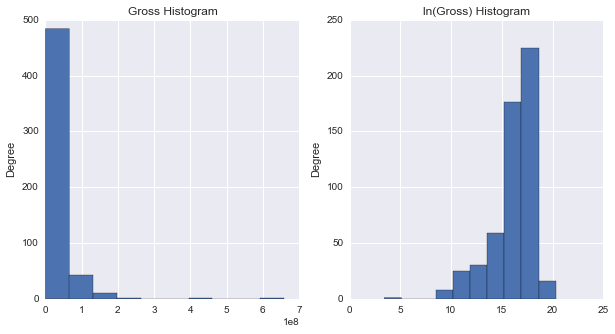

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
df2['gross'].plot(ax = axes[0], kind = 'hist', title = 'Gross Histogram')
df2['log_gross'].plot(ax = axes[1], kind = 'hist', title = 'ln(Gross) Histogram')

###Create some log columns

In [14]:
df2['log_runtime'] = df2['runtime'].apply(lambda x: np.log(x))
df2['log_budget'] = df2['budget'].apply(lambda x: np.log(x))
df2['log_gross'] = df2['gross'].apply(lambda x: np.log(x))

In [15]:
df2['budget_squared'] = df2['budget'].apply(lambda x: (x**2))

###Looks more normally distributed now!

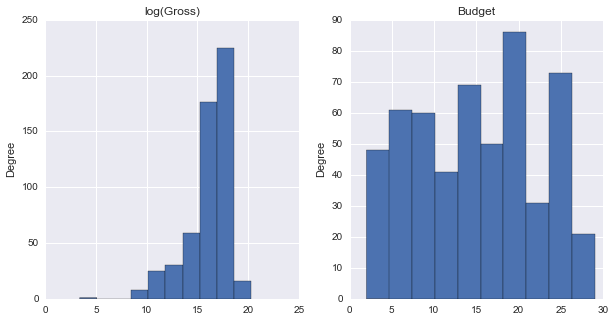

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
df2['log_gross'].plot(ax = axes[0], kind = 'hist', title = 'log(Gross)')
df2['budget'].plot(ax = axes[1], kind = 'hist', title = 'Budget')

###Check top grossing genres

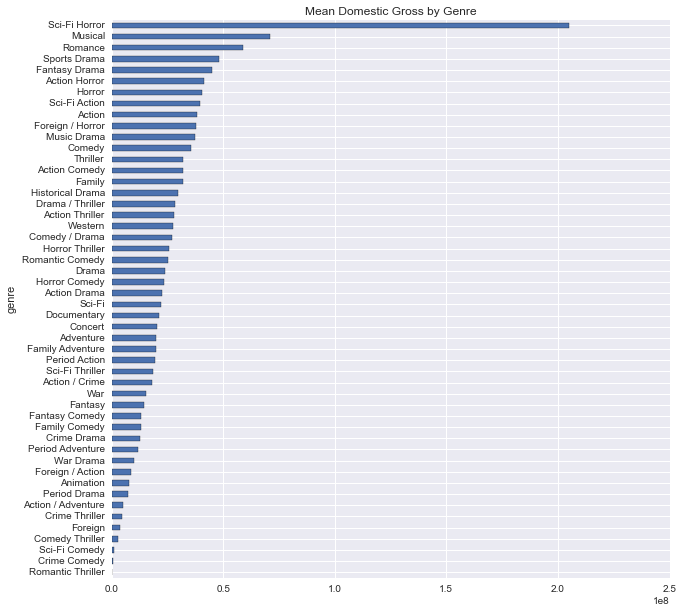

In [77]:
df2.groupby('genre')[['gross']].mean().sort('gross', ascending = True).plot(figsize = (10,10), kind = 'barh', legend = False, title = 'Mean Domestic Gross by Genre')

In [139]:
test = df2.groupby('genre')[['gross']].mean()
test['Count'] = df2.groupby('genre')[['gross']].count()
test.sort('gross', ascending = False)

,gross,Count
genre,,
Sci-Fi Horror,2.051282e+08,2
Musical,7.118108e+07,2
Romance,5.881198e+07,16
Sports Drama,4.825208e+07,12
Fantasy Drama,4.509037e+07,1
Action Horror,4.122693e+07,2
Horror,4.032695e+07,56
Sci-Fi Action,3.945102e+07,2
Action,3.829144e+07,9


### Check top genres by count

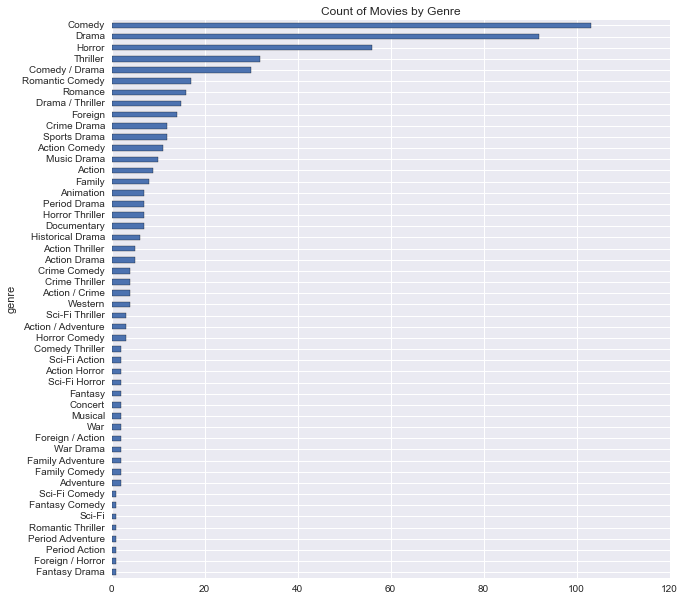

In [83]:
df2.groupby('genre')[['gross']].count().sort('gross', ascending = True).plot(figsize = (10,10), kind = 'barh', legend = False, title = 'Count of Movies by Genre')

###Create categories for top unique grossing genres

In [20]:
genre_list = ['Comedy', 'Drama', 'Horror', 'Romance', 'Thriller', 'Sci-Fi', 'Music', 'Action', 'Adventure', 'Historical', \
             'Family', 'War', 'Sports', 'Crime', 'Animation']
  
for genre in genre_list:
    df2[genre] = create_genre_column(df2, genre)


###Create a new column for genres that concatenates all the individual columns

In [21]:
df_comedy = get_genre_dataframes(df2, 'Comedy')
df_drama = get_genre_dataframes(df2, 'Drama')
df_horror = get_genre_dataframes(df2, 'Horror')
df_romance = get_genre_dataframes(df2, 'Romance')
df_thriller = get_genre_dataframes(df2, 'Thriller')
df_scifi = get_genre_dataframes(df2, 'Sci-Fi')
df_music = get_genre_dataframes(df2, 'Music')
df_action = get_genre_dataframes(df2, 'Action')
df_adventure = get_genre_dataframes(df2, 'Adventure')
df_historical = get_genre_dataframes(df2, 'Historical')
df_family = get_genre_dataframes(df2, 'Family')
df_war = get_genre_dataframes(df2, 'War')
df_sports = get_genre_dataframes(df2, 'Sports')
df_crime = get_genre_dataframes(df2, 'Crime')
df_animation = get_genre_dataframes(df2, 'Animation')

In [89]:
final_df = df_comedy.copy()
final_df = final_df.append(df_drama)
final_df = final_df.append(df_horror)
final_df = final_df.append(df_romance)
final_df = final_df.append(df_thriller)
final_df = final_df.append(df_scifi)
final_df = final_df.append(df_music)
final_df = final_df.append(df_action)
final_df = final_df.append(df_adventure)
final_df = final_df.append(df_historical)
final_df = final_df.append(df_family)
final_df = final_df.append(df_war)
final_df = final_df.append(df_sports)
final_df = final_df.append(df_crime)
final_df = final_df.append(df_animation)
final_df[['genre', 'budget', 'log_gross']].head()


,genre,budget,log_gross
21 and Over (2013),Comedy,13,17.061316
30 Minutes or Less (2011),Comedy,28,17.427885
50/50 (2011),Comedy,8,17.371264
A Haunted House 2 (2014),Comedy,4,16.667920
A Very Harold & Kumar 3D Christmas (2011),Comedy,19,17.372601


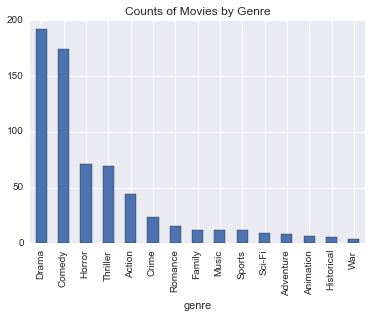

In [75]:
final_df[['log_gross', 'genre']].groupby('genre').count().sort('log_gross', ascending = False).plot(kind = 'bar', legend = False, title = 'Counts of Movies by Genre')

In [132]:
temp = final_df[['gross', 'genre']].groupby('genre').mean()
temp['Count'] = final_df[['gross', 'genre']].groupby('genre').count()
temp.sort('gross',ascending = False)
temp = temp.rename(columns={'gross': 'Average Gross'})
temp.sort('Average Gross', ascending = False)

,Average Gross,Count
genre,,
Sci-Fi,63104571.666667,9
Romance,58811983.125000,16
Sports,48252081.833333,12
Music,43127042.083333,12
Horror,42822486.408451,71
Comedy,30754760.241379,174
Historical,29590486.333333,6
Action,28083568.386364,44
Thriller,26834460.318841,69


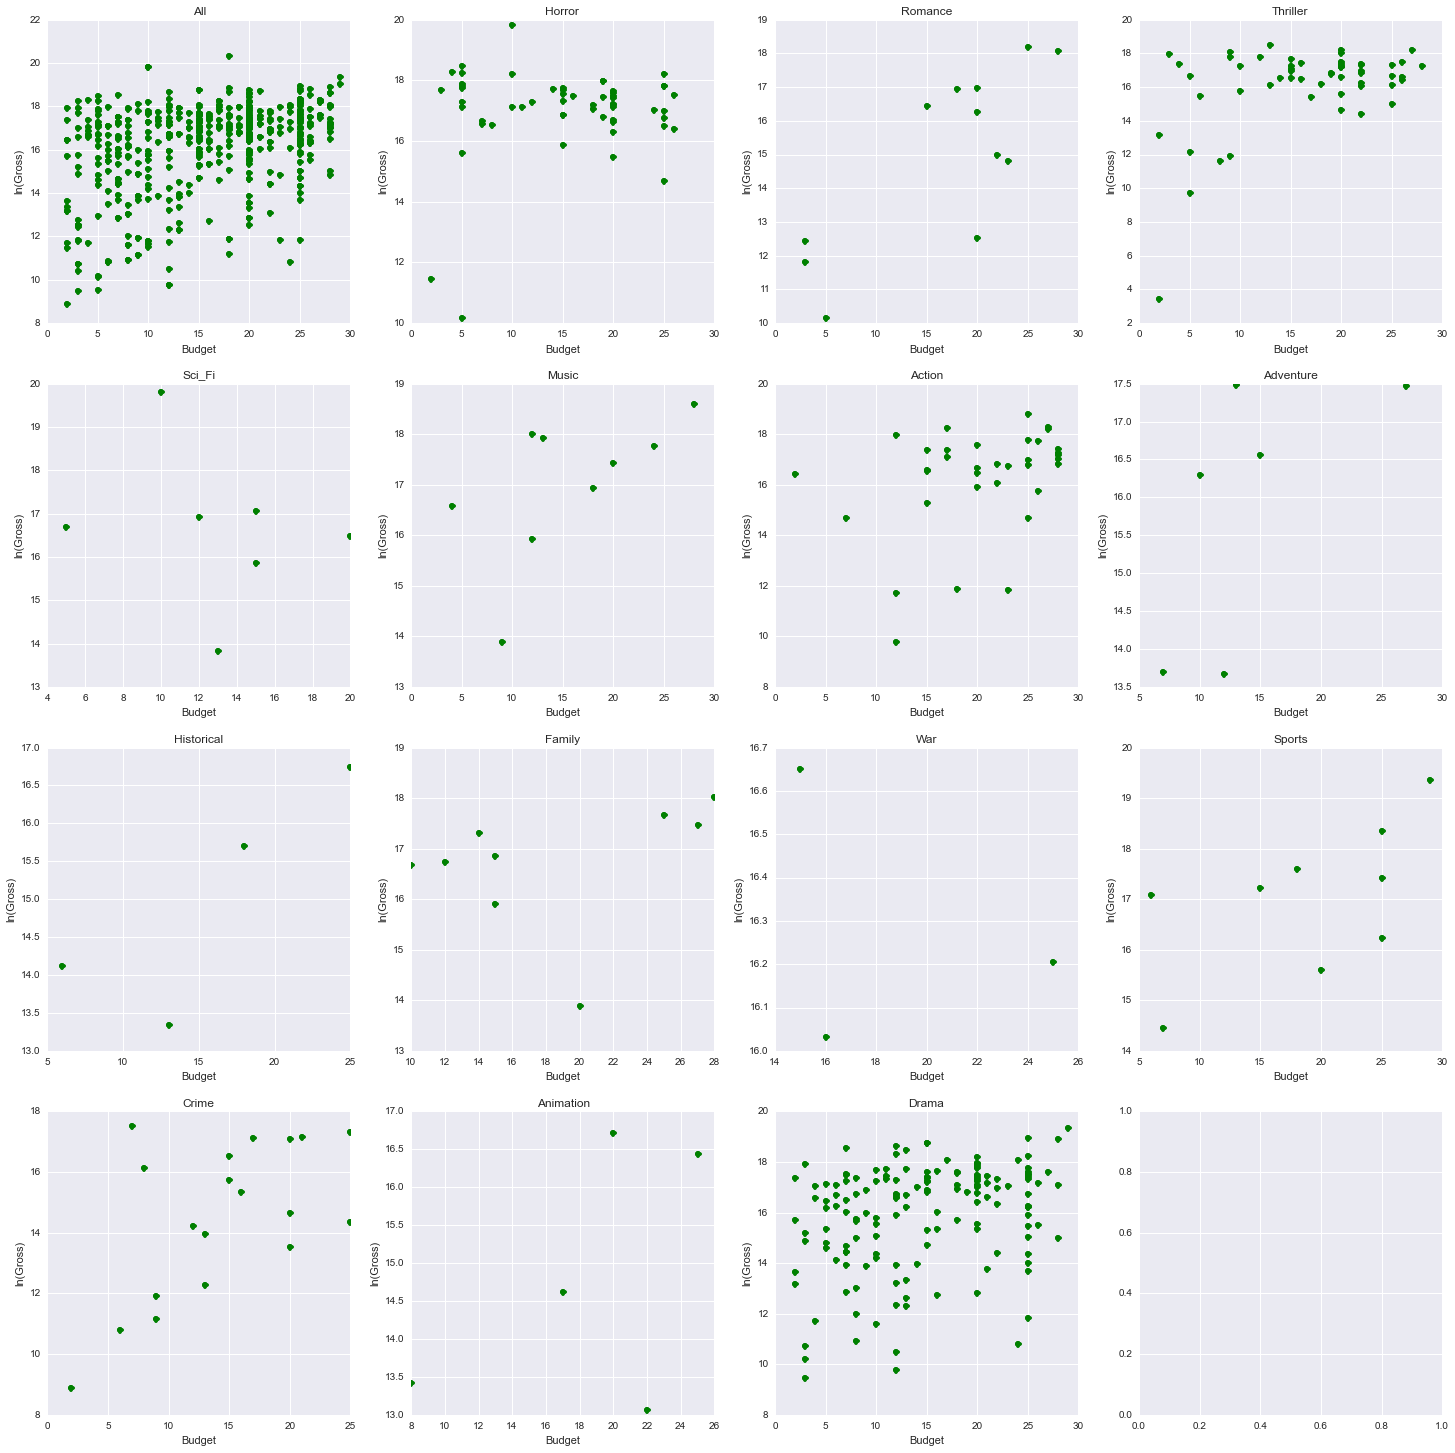

In [109]:
fig, axes = plt.subplots(nrows=4, ncols=4,figsize=(25,25))
perform_linear_regression_all(final_df, axes[0,0], 'All')
perform_linear_regression_all(df_horror, axes[0,1], 'Horror')
perform_linear_regression_all(df_romance, axes[0,2], 'Romance')
perform_linear_regression_all(df_thriller, axes[0,3], 'Thriller')
perform_linear_regression_all(df_scifi, axes[1,0], 'Sci_Fi')
perform_linear_regression_all(df_music, axes[1,1], 'Music')
perform_linear_regression_all(df_action, axes[1,2], 'Action')
perform_linear_regression_all(df_adventure, axes[1,3], 'Adventure')
perform_linear_regression_all(df_historical, axes[2,0], 'Historical')
perform_linear_regression_all(df_family, axes[2,1], 'Family')
perform_linear_regression_all(df_war, axes[2,2], 'War')
perform_linear_regression_all(df_sports, axes[2,3], 'Sports')
perform_linear_regression_all(df_crime, axes[3,0], 'Crime')
perform_linear_regression_all(df_animation, axes[3,1], 'Animation')
perform_linear_regression_all(df_drama, axes[3,2], 'Drama')



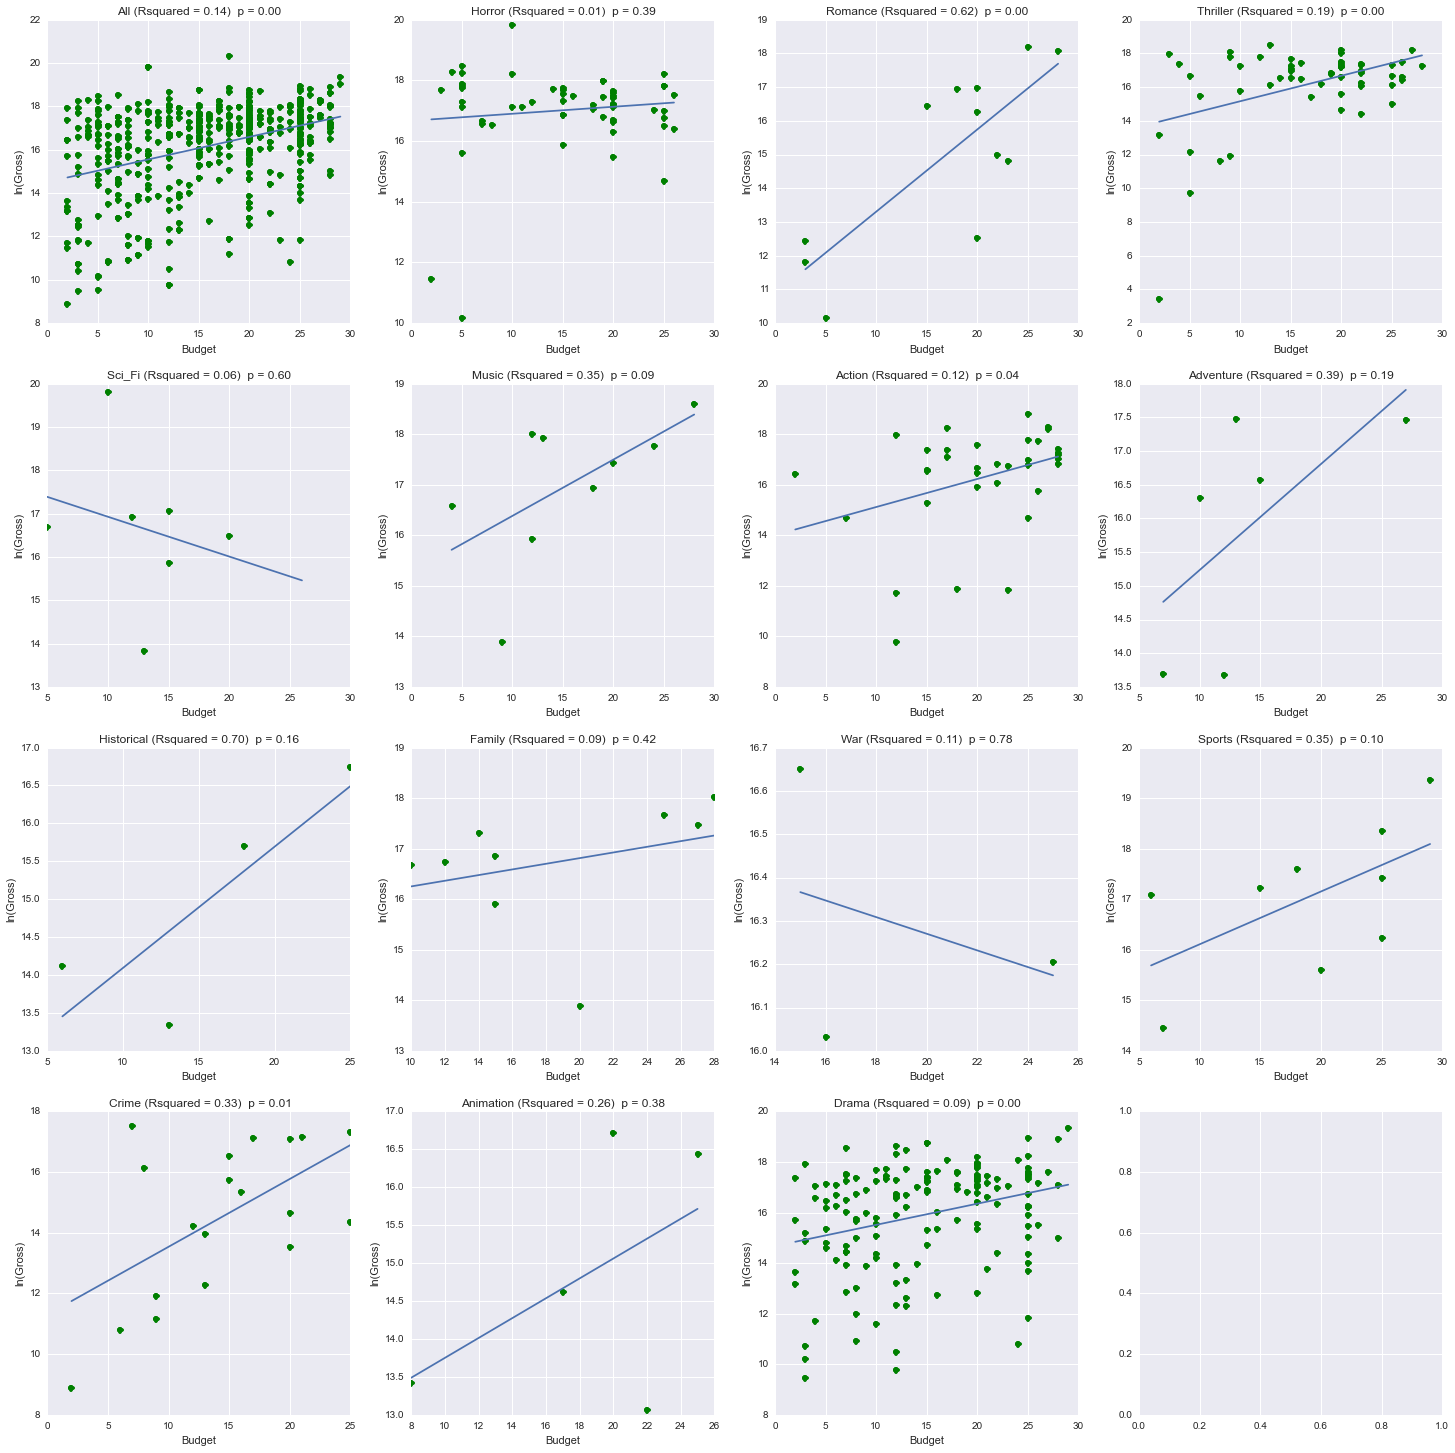

In [122]:
fig, axes = plt.subplots(nrows=4, ncols=4,figsize=(25,25))
perform_linear_regression(final_df, axes[0,0], 'All')
perform_linear_regression(df_horror, axes[0,1], 'Horror')
perform_linear_regression(df_romance, axes[0,2], 'Romance')
perform_linear_regression(df_thriller, axes[0,3], 'Thriller')
perform_linear_regression(df_scifi, axes[1,0], 'Sci_Fi')
perform_linear_regression(df_music, axes[1,1], 'Music')
perform_linear_regression(df_action, axes[1,2], 'Action')
perform_linear_regression(df_adventure, axes[1,3], 'Adventure')
perform_linear_regression(df_historical, axes[2,0], 'Historical')
perform_linear_regression(df_family, axes[2,1], 'Family')
perform_linear_regression(df_war, axes[2,2], 'War')
perform_linear_regression(df_sports, axes[2,3], 'Sports')
perform_linear_regression(df_crime, axes[3,0], 'Crime')
perform_linear_regression(df_animation, axes[3,1], 'Animation')
perform_linear_regression(df_drama, axes[3,2], 'Drama')


###Linear Regression

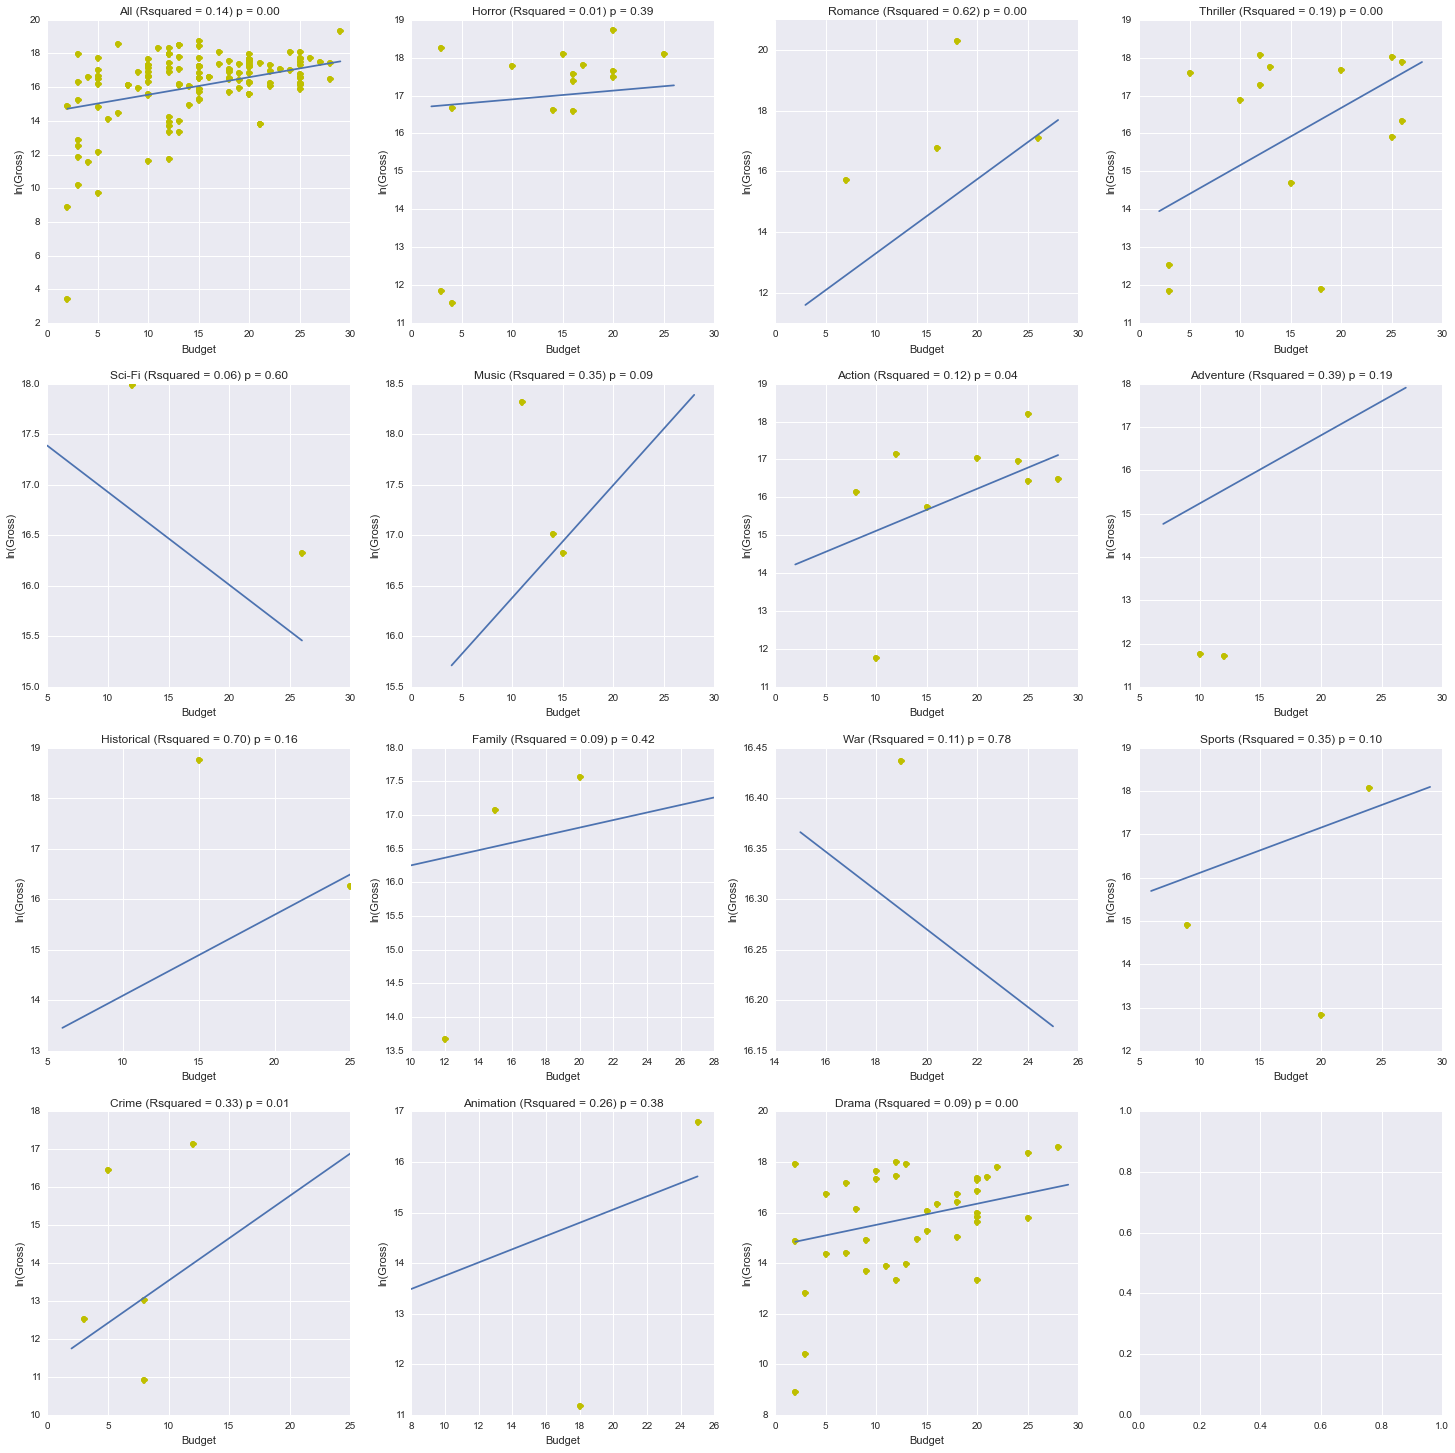

In [115]:
fig, axes = plt.subplots(nrows=4, ncols=4,figsize=(25,25))
perform_linear_regression1(final_df, axes[0,0], 'All')
perform_linear_regression1(df_horror, axes[0,1], 'Horror')
perform_linear_regression1(df_romance, axes[0,2], 'Romance')
perform_linear_regression1(df_thriller, axes[0,3], 'Thriller')
perform_linear_regression1(df_scifi, axes[1,0], 'Sci-Fi')
perform_linear_regression1(df_music, axes[1,1], 'Music')
perform_linear_regression1(df_action, axes[1,2], 'Action')
perform_linear_regression1(df_adventure, axes[1,3], 'Adventure')
perform_linear_regression1(df_historical, axes[2,0], 'Historical')
perform_linear_regression1(df_family, axes[2,1], 'Family')
perform_linear_regression1(df_war, axes[2,2], 'War')
perform_linear_regression1(df_sports, axes[2,3], 'Sports')
perform_linear_regression1(df_crime, axes[3,0], 'Crime')
perform_linear_regression1(df_animation, axes[3,1], 'Animation')
perform_linear_regression1(df_drama, axes[3,2], 'Drama')


In [569]:
df_sports.sort('gross', ascending = False)

,log_gross,gross,log_budget,budget,runtime,budget_squared,genre
The Blind Side (2009),19.360530,255959475,3.367296,29,126,841,Sports
The Waterboy (1998),18.899964,161491646,3.135494,23,90,529,Sports
DodgeBall: A True Underdog Story (2004),18.554571,114326736,2.995732,20,97,400,Sports
The Fighter (2010),18.354723,93617009,3.218876,25,114,625,Sports
The Rookie (2002),18.140968,75600072,3.091042,22,129,484,Sports
Rocky Balboa (2006),18.067869,70270943,3.178054,24,102,576,Sports
Cool Runnings (1993),18.047532,68856263,2.639057,14,98,196,Sports
Bring It On (2000),18.040576,68379000,3.332205,28,98,784,Sports
Varsity Blues (1999),17.783804,52894169,2.772589,16,104,256,Sports
Soul Surfer (2011),17.596363,43853424,2.890372,18,105,324,Sports


In [574]:
final_df[final_df['budget']<5].sort('gross')

,log_gross,gross,log_budget,budget,runtime,budget_squared,genre
Zyzzyx Road (2006),3.401197,30,0.693147,2,90,4,Thriller
Gangster's Paradise: Jerusalema (2010),8.894807,7294,0.693147,2,120,4,Drama
Gangster's Paradise: Jerusalema (2010),8.894807,7294,0.693147,2,120,4,Crime
Christmas at Maxwell's (2006),9.455715,12781,1.098612,3,94,9,Drama
Cape of Good Hope (2005),10.200030,26904,1.098612,3,107,9,Drama
Local Color (2007),10.397818,32788,1.098612,3,107,9,Drama
Every Day (2011),10.737027,46029,1.098612,3,93,9,Drama
Every Day (2011),10.737027,46029,1.098612,3,93,9,Comedy
The Last Time I Committed Suicide (1997),10.744235,46362,1.386294,4,92,16,Drama
I Spit on Your Grave (2010),11.440903,93051,0.693147,2,108,4,Horror


In [591]:
df_scifi[['genre', 'gross']].sort('gross', ascending = False)

,genre,gross
Star Wars (1977),Sci-Fi,460998007
Jurassic Park 3D (2013),Sci-Fi,402453882
The Empire Strikes Back (1980),Sci-Fi,290475067
Back to the Future (1985),Sci-Fi,210609762
Close Encounters of the Third Kind (1977),Sci-Fi,132088635
Alien (1979),Sci-Fi,80931801
Chronicle (2012) (2012),Sci-Fi,64575175
The Butterfly Effect (2004),Sci-Fi,57938693
2001: A Space Odyssey (1968),Sci-Fi,56954992
Robocop (1987),Sci-Fi,53424681


In [81]:
df2[df2['genre']=='Sci-Fi Horror']

,gross,date,budget,genre,runtime,year,log_runtime,log_budget,log_gross,budget_squared,...,Sci-Fi,Music,Action,Adventure,Historical,Family,War,Sports,Crime,Animation
Jurassic Park 3D (2013),402453882,2013-04-05,10,Sci-Fi Horror,127,2013,4.844187,2.302585,19.813091,100,...,1,0,0,0,0,0,0,0,0,0
Slither (2006),7802450,2006-03-31,15,Sci-Fi Horror,96,2006,4.564348,2.708050,15.869948,225,...,1,0,0,0,0,0,0,0,0,0


In [85]:
df2[df2['genre']=='Romance'].sort('gross', ascending = False)

,gross,date,budget,genre,runtime,year,log_runtime,log_budget,log_gross,budget_squared,...,Sci-Fi,Music,Action,Adventure,Historical,Family,War,Sports,Crime,Animation
Titanic 3D (2012),658672302,2012-04-04,18,Romance,194,2012,5.267858,2.890372,20.305737,324,...,0,0,0,0,0,0,0,0,0,0
Dear John (2010),80014842,2010-02-05,25,Romance,108,2010,4.682131,3.218876,18.197723,625,...,0,0,0,0,0,0,0,0,0,0
Safe Haven (2013),71349120,2013-02-14,28,Romance,115,2013,4.744932,3.332205,18.083096,784,...,0,0,0,0,0,0,0,0,0,0
The Best of Me (2014),26766213,2014-10-17,26,Romance,117,2014,4.762174,3.258097,17.102651,676,...,0,0,0,0,0,0,0,0,0,0
Endless Love (2014) (2014),23438250,2014-02-14,20,Romance,103,2014,4.634729,2.995732,16.969880,400,...,0,0,0,0,0,0,0,0,0,0
Love Happens (2009),22965110,2009-09-18,18,Romance,109,2009,4.691348,2.890372,16.949487,324,...,0,0,0,0,0,0,0,0,0,0
Remember Me (2010),19068240,2010-03-12,16,Romance,128,2010,4.852030,2.772589,16.763535,256,...,0,0,0,0,0,0,0,0,0,0
One Day (2011),13843771,2011-08-19,15,Romance,107,2011,4.672829,2.708050,16.443346,225,...,0,0,0,0,0,0,0,0,0,0
The Last Kiss (2006) (2006),11614790,2006-09-15,20,Romance,104,2006,4.644391,2.995732,16.267790,400,...,0,0,0,0,0,0,0,0,0,0
Bride and Prejudice (2005),6605592,2005-02-11,7,Romance,111,2005,4.709530,1.945910,15.703427,49,...,0,0,0,0,0,0,0,0,0,0
